# 📦 Import Libraries

In [100]:
import traci
import folium
import joblib

In [101]:
import numpy as np
import pandas as pd

In [102]:
import matplotlib.pyplot as plt

In [103]:
from utils.data_acquisition import *
from utils.data_preprocessing import *
from utils.data_visualize import *
from utils.teda import TEDADetect

teda_detect = TEDADetect()

In [104]:
plot_size = (12, 6)

graph_colors = {
  "black": "#1F1E1F",
  "blue": "#03A9CE",
}

text_colors = {
  "title": "#262626",
  "subtitle": "#646464",
}

fig_path = "./figures/"
files_path = "./files/"

if not os.path.exists(fig_path):
    os.makedirs(fig_path)

if not os.path.exists(files_path):
    os.makedirs(files_path)

# 💾 Data Acquisition

In [105]:
LGBMRegressor_ethanol_afr = joblib.load("./models/LGBMRegressor_ethanol_afr.pkl")
LGBMRegressor_gasoline_afr = joblib.load("./models/LGBMRegressor_gasoline_afr.pkl")

In [106]:
XGBRegressor_ethanol_maf = joblib.load("./models/XGBRegressor_ethanol_maf.pkl")
XGBRegressor_gasoline_maf = joblib.load("./models/XGBRegressor_gasoline_maf.pkl")

In [107]:
data_test_gasoline = pd.read_csv("./data/[Gasolina] Trajeto Casa-Escola-UFRN/trackLog-2022-Dec-01_06-43-57_qui.csv")
data_test_ethanol = pd.read_csv("./data/[Etanol] Trajeto Casa-Escola-UFRN/trackLog-2023-Feb-13_06-38-49_seg.csv")

# 🧩 Data Modelling

In [108]:
SELECTED_COLUMNS = [
  "DeviceTime",
  "Latitude",
  "Longitude",
  "Speed(OBD)(km/h)",
  "AirFuelRatio(Commanded)(:1)",
  "MassAirFlowRate(g/s)",
  "Acceleration"
]

In [109]:
data_test_gasoline = data_test_gasoline.iloc[:655]
data_test_gasoline = remove_space_in_columns(data_test_gasoline)
data_test_gasoline["Acceleration"] = compute_acceleration(data_test_gasoline)
data_test_gasoline = filter_columns(data_test_gasoline, SELECTED_COLUMNS)
data_test_gasoline["CO2Emission(g)"] = compute_co2(
    data_test_gasoline["AirFuelRatio(Commanded)(:1)"],
    data_test_gasoline["MassAirFlowRate(g/s)"],
    "gasoline"
)

data_test_gasoline.drop(columns=["DeviceTime"], inplace=True)

In [110]:
data_test_ethanol = data_test_ethanol.iloc[:747]
data_test_ethanol = remove_space_in_columns(data_test_ethanol)
data_test_ethanol["Acceleration"] = compute_acceleration(data_test_ethanol)
data_test_ethanol = filter_columns(data_test_ethanol, SELECTED_COLUMNS)
data_test_ethanol["CO2Emission(g)"] = compute_co2(
    data_test_ethanol["AirFuelRatio(Commanded)(:1)"],
    data_test_ethanol["MassAirFlowRate(g/s)"],
    "gasoline"
)

data_test_ethanol.drop(columns=["DeviceTime"], inplace=True)

# Simulation

In [111]:
CUSTOM_ROUTE = [
    (-35.22074600, -5.820143000),
    (-35.21595605, -5.812192060),
    (-35.21110018, -5.813623130),
    (-35.20746110, -5.804566941),
    (-35.20355062, -5.794003606)
]

## Gasoline

In [112]:
traci.start(["sumo", "-c", f"{files_path}osm.sumocfg"], label="MDPI-SIM-GASOLINE")

df = pd.DataFrame()

edges = [traci.simulation.convertRoad(*coord, isGeo=True)[0] for coord in CUSTOM_ROUTE]

route = []

for i in range(len(edges) - 1):
    route += traci.simulation.findRoute(edges[i], edges[i + 1]).edges

traci.route.add("trip", route)
traci.vehicle.add("vehTest", "trip")

while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()

    for veh in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(veh)
        lon, lat = traci.simulation.convertGeo(x, y)

        simulation_time = traci.simulation.getTime()
        veh_id = veh
        speed = traci.vehicle.getSpeed(veh) * 3.6
        acceleration = traci.vehicle.getAcceleration(veh)
        distance = traci.vehicle.getDistance(veh)
        fuel_consumption = traci.vehicle.getFuelConsumption(veh)
        eletric_energy_consumption = traci.vehicle.getElectricityConsumption(veh)
        noise_emission = traci.vehicle.getNoiseEmission(veh)

        co2_emission = compute_co2(
            LGBMRegressor_gasoline_afr.predict([[lat, lon, speed, acceleration]])[0],
            XGBRegressor_gasoline_maf.predict([[lat, lon, speed, acceleration]])[0],
            fuel_type="gasoline"
        )

        df = pd.concat(
            [
                df,
                pd.DataFrame({
                    "SimulationTime(s)": simulation_time,
                    "VehicleID": veh_id,
                    "Speed(km/h)": speed,
                    "Acceleration(m/s^2)": acceleration,
                    "Distance(odometer)": distance,
                    "Latitude": lat,
                    "Longitude": lon,
                    "FuelConsumption(mg/s)": fuel_consumption,
                    "EletricEnergyConsumption(Wh/s)": eletric_energy_consumption,
                    "NoiseEmission(dB)": noise_emission,
                    "CO2Emission(g)": co2_emission
                }, index=[0])
            ]
        )

df.to_csv(f"{files_path}vehicle_gasoline.csv", index=False)
traci.close()

## Ethanol

In [113]:
traci.start(["sumo", "-c", f"{files_path}osm.sumocfg"], label="MDPI-SIM-ETHANOL")

df = pd.DataFrame()

edges = [traci.simulation.convertRoad(*coord, isGeo=True)[0] for coord in CUSTOM_ROUTE]

route = []

for i in range(len(edges) - 1):
    route += traci.simulation.findRoute(edges[i], edges[i + 1]).edges

traci.route.add("trip", list(route))
traci.vehicle.add("vehTest", "trip")

while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()

    for veh in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(veh)
        lon, lat = traci.simulation.convertGeo(x, y)

        simulation_time = traci.simulation.getTime()
        veh_id = veh
        speed = traci.vehicle.getSpeed(veh) * 3.6
        acceleration = traci.vehicle.getAcceleration(veh)
        distance = traci.vehicle.getDistance(veh)
        fuel_consumption = traci.vehicle.getFuelConsumption(veh)
        eletric_energy_consumption = traci.vehicle.getElectricityConsumption(veh)
        noise_emission = traci.vehicle.getNoiseEmission(veh)

        co2_emission = compute_co2(
            LGBMRegressor_ethanol_afr.predict([[lat, lon, speed, acceleration]])[0],
            XGBRegressor_ethanol_maf.predict([[lat, lon, speed, acceleration]])[0],
            fuel_type="ethanol"
        )

        df = pd.concat(
            [
                df,
                pd.DataFrame({
                    "SimulationTime(s)": simulation_time,
                    "VehicleID": veh_id,
                    "Speed(km/h)": speed,
                    "Acceleration(m/s^2)": acceleration,
                    "Distance(odometer)": distance,
                    "Latitude": lat,
                    "Longitude": lon,
                    "FuelConsumption(mg/s)": fuel_consumption,
                    "EletricEnergyConsumption(Wh/s)": eletric_energy_consumption,
                    "NoiseEmission(dB)": noise_emission,
                    "CO2Emission(g)": co2_emission
                }, index=[0])
            ]
        )

df.to_csv(f"{files_path}vehicle_ethanol.csv", index=False)
traci.close()

# Data Analysis and Visualization

In [114]:
df_gasoline = pd.read_csv(f"{files_path}vehicle_gasoline.csv")
df_ethanol = pd.read_csv(f"{files_path}vehicle_ethanol.csv")

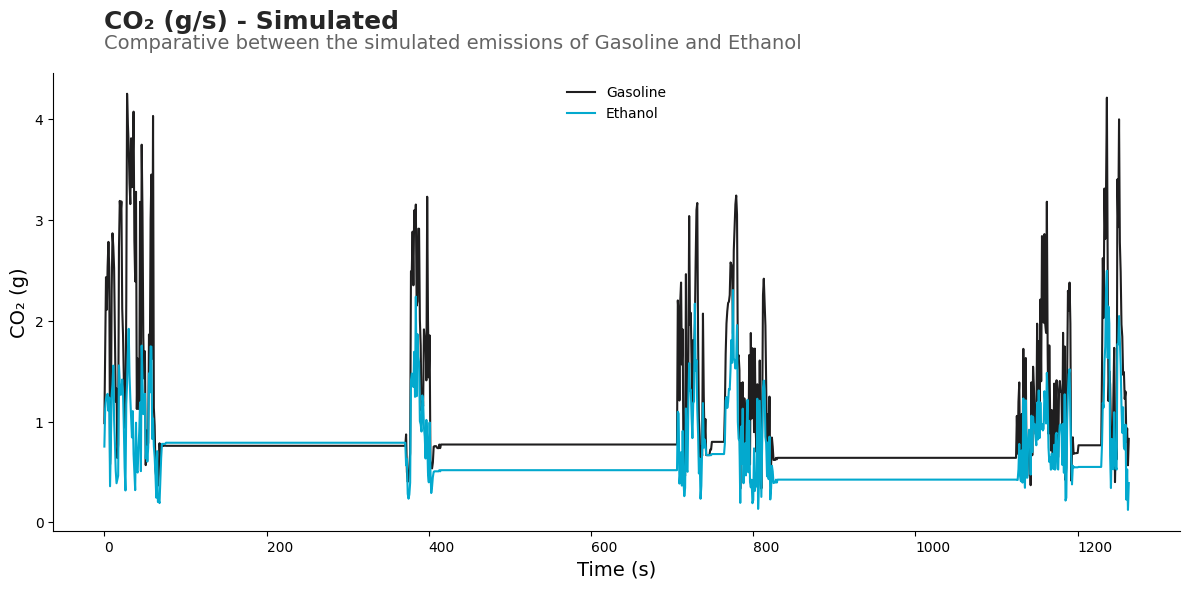

In [115]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("CO₂ (g)", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=14)

plt.xticks(rotation=0, ha="left")

ax.plot(df_gasoline["CO2Emission(g)"], label="Gasoline", color=graph_colors["black"])
ax.plot(df_ethanol["CO2Emission(g)"], label="Ethanol", color=graph_colors["blue"])

# plt.text(0, 4.9, "CO₂ (g/s) - Simulated", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 4.7, "Comparative between the simulated emissions of Gasoline and Ethanol", fontsize=14, color=text_colors["subtitle"])

ax.legend(loc="upper center").set_frame_on(False)

plt.tight_layout()
plt.savefig(f"{fig_path}sumo_gasoline_vs_ethanol_co2.png")
plt.show()

In [116]:
cumsum_gasoline = df_gasoline["CO2Emission(g)"].cumsum()
cumsum_ethanol = df_ethanol["CO2Emission(g)"].cumsum()

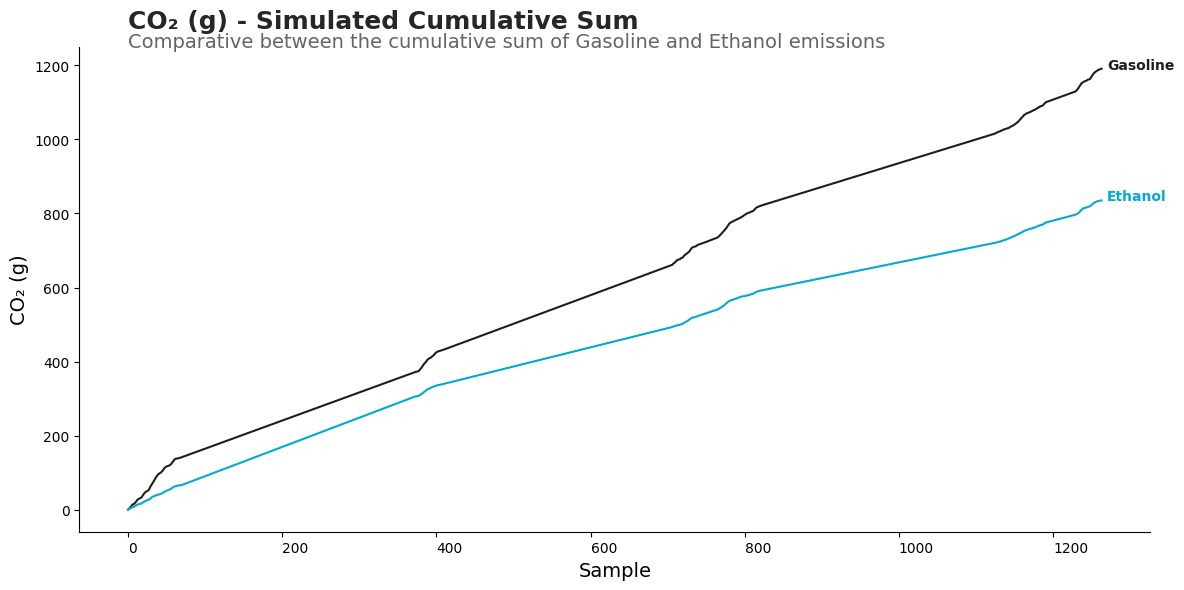

In [117]:
fig, ax = plt.subplots(figsize=plot_size)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("CO₂ (g)", fontsize=14)
ax.set_xlabel("Sample", fontsize=14)

plt.xticks(rotation=0, ha="left")

ax.plot(cumsum_gasoline, label="Gasoline", color=graph_colors["black"])
ax.plot(cumsum_ethanol, label="Ethanol", color=graph_colors["blue"])

# plt.text(0, 1300, "CO₂ (g) - Simulated Cumulative Sum", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 1250, "Comparative between the cumulative sum of Gasoline and Ethanol emissions", fontsize=14, color=text_colors["subtitle"])

plt.text(1270, cumsum_gasoline.iloc[-1], "Gasoline", weight="bold", color=graph_colors["black"])
plt.text(1270, cumsum_ethanol.iloc[-1], "Ethanol", weight="bold", color=graph_colors["blue"])

plt.tight_layout()
plt.savefig(f"{fig_path}simulated_cumsum_co2.png")
plt.show()

## Map Plotting

In [118]:
co2_colors = {
  "#fdff7d": 1.0,
  "#fcff33": 2.0,
  "#ffd333": 3.0,
  "#fab00f": 4.0,
  "#fa6d0f": 5.0,
  "#ff523b": 6.0
}

### Gasoline

In [119]:
route_map_gasoline = routeplot(data_test_gasoline, "CO2Emission(g)", color_list=co2_colors)

route_map_gasoline

In [120]:
route_map_gasoline = routeplot(df_gasoline, "CO2Emission(g)", color_list=co2_colors)

route_map_gasoline

### Ethanol

In [121]:
route_map_gasoline = routeplot(data_test_ethanol, "CO2Emission(g)", color_list=co2_colors)

route_map_gasoline

In [122]:
route_map_ethanol = routeplot(df_ethanol, "CO2Emission(g)", color_list=co2_colors)

route_map_ethanol